## Частина 2

​

В цій частині ми знову будемо працювати з датасетом fashion_mnist.



На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.



Навчіть отриману мережу на даних із датасету fashion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.



Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [ ]:
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

fashion_mnist = tf.keras.datasets.fashion_mnist


In [ ]:
# Завантаження датасету Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:

# Перевірка форми даних
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [ ]:
# Зміна розмірності зображень на 32x32
train_images = tf.image.resize(train_images[..., tf.newaxis], [32, 32])
test_images = tf.image.resize(test_images[..., tf.newaxis], [32, 32])

In [ ]:
# # Збільшення кількості каналів до 3 для сумісності з VGG16
# x_train = np.stack([x_train]*3, axis=-1)
# x_test = np.stack([x_test]*3, axis=-1)

# # Зміна розміру зображень до 224x224 для сумісності з VGG16
# x_train = tf.image.resize(x_train, (224, 224))
# x_test = tf.image.resize(x_test, (224, 224))

# Збільшення кількості каналів у зображеннях з 1 до 3
train_images = tf.repeat(train_images, 3, axis=-1)
test_images = tf.repeat(test_images, 3, axis=-1)

In [ ]:
print(train_images.shape)
print(test_images.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
# # Нормалізація даних
# x_train = preprocess_input(x_train)
# x_test = preprocess_input(x_test)

# # One-hot енкодінг міток
# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)

# Нормалізація піксельних значень до діапазону [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
# Створення об'єкта генератора даних з параметрами аугментації для навчальних даних
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Генератор даних для навчального набору
train_generator = train_datagen.flow(train_images, train_labels, batch_size=64)

# Генератор даних для валідаційного набору без аугментації
validation_datagen = ImageDataGenerator()

# Генератор даних для валідаційного набору
validation_generator = validation_datagen.flow(test_images, test_labels, batch_size=64)

In [ ]:
# Завантаження VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Визначення моделі
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="softmax"), # Зміна на 10 вихідних класів, якщо це класифікація для Fashion MNIST
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:

# Компіляція моделі
model.compile(
    loss="sparse_categorical_crossentropy", # Зміна на sparse_categorical_crossentropy для багатокласової класифікації
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)


In [ ]:

# Тренування моделі
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100, # Зменшення кількості епох для швидшого тестування
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 130s 1s/step - loss: 2.2487 - accuracy: 0.1784 - val_loss: 2.1649 - val_accuracy: 0.2384
Epoch 2/100
100/100 [==============================] - 125s 1s/step - loss: 2.0674 - accuracy: 0.3303 - val_loss: 1.9792 - val_accuracy: 0.4272
Epoch 3/100
100/100 [==============================] - 125s 1s/step - loss: 1.9067 - accuracy: 0.4613 - val_loss: 1.8154 - val_accuracy: 0.5169
Epoch 4/100
100/100 [==============================] - 129s 1s/step - loss: 1.7642 - accuracy: 0.5387 - val_loss: 1.6856 - val_accuracy: 0.5691
Epoch 5/100
100/100 [==============================] - 126s 1s/step - loss: 1.6280 - accuracy: 0.5841 - val_loss: 1.5508 - val_accuracy: 0.6172
Epoch 6/100
100/100 [==============================] - 126s 1s/step - loss: 1.5296 - accuracy: 0.6070 - val_loss: 1.4442 - val_accuracy: 0.6372
Epoch 7/100
100/100 [==============================] - 126s 1s/step - loss: 1.4286 - accuracy: 0.6253 - val_loss: 1.3406 - val_accuracy:

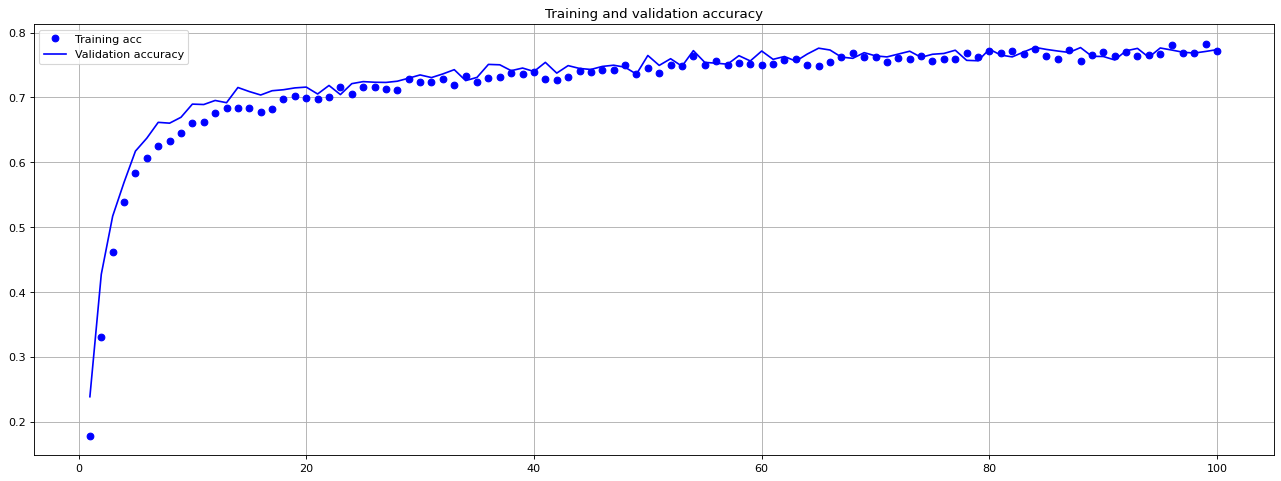

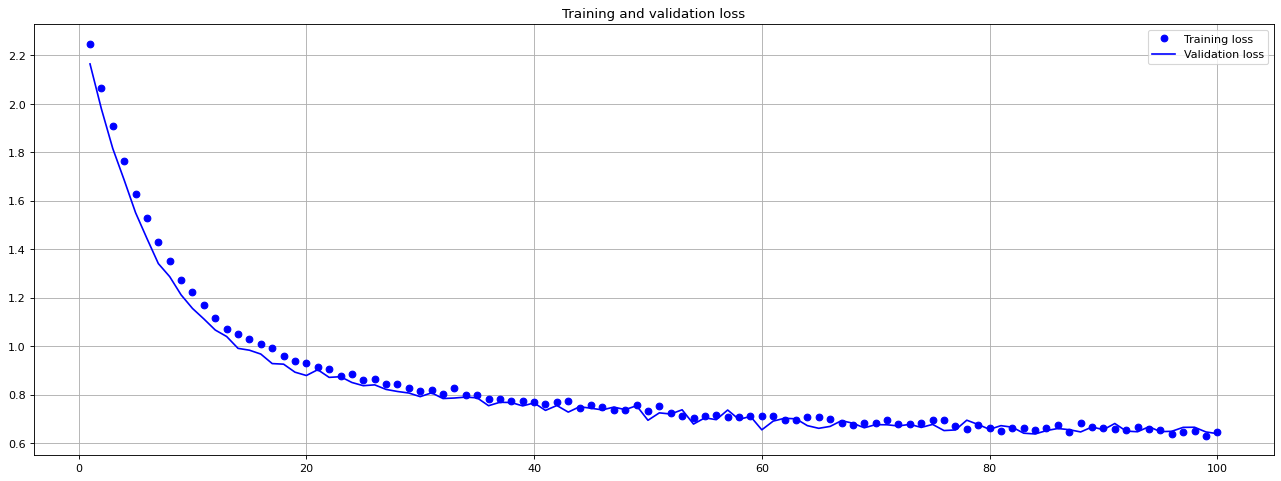

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Отримання передбачень для тестових даних
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Генерація classification report
report = classification_report(test_labels, predicted_classes)
print(report)

# Перевірка точності на тестових даних за допомогою генератора
test_loss, test_acc = model.evaluate(validation_generator, steps=len(test_images) // 64, verbose=2)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 134s 428ms/step
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      1000
           1       0.98      0.90      0.94      1000
           2       0.62      0.77      0.69      1000
           3       0.82      0.63      0.71      1000
           4       0.58      0.73      0.65      1000
           5       0.90      0.90      0.90      1000
           6       0.53      0.39      0.45      1000
           7       0.90      0.84      0.87      1000
           8       0.90      0.91      0.90      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

156/156 - 124s - loss: 0.6380 - accuracy: 0.7765 - 124s/epoch - 795ms/step
Test accuracy: 0.7765424847602844


In [ ]:
model.save("model_VGG16.keras")

## 2. Донавчання моделі

In [1]:
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

fashion_mnist = tf.keras.datasets.fashion_mnist

In [2]:
# Завантаження датасету Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Зміна розмірності зображень на 150x150
train_images = tf.image.resize(train_images[..., tf.newaxis], [32, 32])
test_images = tf.image.resize(test_images[..., tf.newaxis], [32, 32])

# Збільшення кількості каналів у зображеннях з 1 до 3
train_images = tf.repeat(train_images, 3, axis=-1)
test_images = tf.repeat(test_images, 3, axis=-1)

# Створення об'єкта генератора даних з параметрами аугментації для навчальних даних
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Генератор даних для навчального набору
train_generator = train_datagen.flow(train_images, train_labels, batch_size=64)

# Генератор даних для валідаційного набору без аугментації
validation_datagen = ImageDataGenerator()

# Генератор даних для валідаційного набору
validation_generator = validation_datagen.flow(test_images, test_labels, batch_size=64)

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [4]:

# розмороження кілька верхніх шарів у створеному раніше conv_base
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
# # Визначаємо модифікову модель
# modified_model = models.Sequential([
#    conv_base,
#    layers.Flatten(),
#    layers.Dense(256, activation="relu"),
#    layers.Dense(1, activation="sigmoid"),
# ])
# Визначаємо модифікову модель
modified_model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Додаємо Dropout для зменшення перенавчання
    layers.Dense(10, activation="softmax"),  # Зміна на 10 класів і функцію активації softmax
])


In [6]:

# # Компілюємо модель
# modified_model.compile(
#     loss="sparse_categorical_crossentropy", # Зміна на sparse_categorical_crossentropy для багатокласової класифікації
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
#     metrics=["accuracy"]
# )
# Компілюємо модель
modified_model.compile(
    loss="sparse_categorical_crossentropy",  # Зміна на sparse_categorical_crossentropy для багатокласової класифікації
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [ ]:
# # Завантаження VGG16
# conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
# conv_base.trainable = False

In [7]:
# # Навчаємо модель
# history_modified_model = modified_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=100,
#     validation_data=validation_generator,
#     validation_steps=50
# )

# Навчання моделі
history = modified_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
938/938 [==============================] - 2971s 3s/step - loss: 1.5300 - accuracy: 0.5480 - val_loss: 0.7030 - val_accuracy: 0.7963
Epoch 2/10
938/938 [==============================] - 2955s 3s/step - loss: 0.7513 - accuracy: 0.7744 - val_loss: 0.5703 - val_accuracy: 0.7990
Epoch 3/10
938/938 [==============================] - 2948s 3s/step - loss: 0.5960 - accuracy: 0.8065 - val_loss: 0.4371 - val_accuracy: 0.8523
Epoch 4/10
938/938 [==============================] - 3045s 3s/step - loss: 0.5059 - accuracy: 0.8336 - val_loss: 0.4173 - val_accuracy: 0.8581
Epoch 5/10
938/938 [==============================] - 2992s 3s/step - loss: 0.4617 - accuracy: 0.8452 - val_loss: 0.3891 - val_accuracy: 0.8644
Epoch 6/10
938/938 [==============================] - 3006s 3s/step - loss: 0.4394 - accuracy: 0.8529 - val_loss: 0.4337 - val_accuracy: 0.8492
Epoch 7/10
938/938 [==============================] - 3012s 3s/step - loss: 0.4165 - accuracy: 0.8611 - val_loss: 0.3970 - val_accuracy:

In [8]:
from sklearn.metrics import classification_report

# Отримання передбачень для тестових даних
predictions = modified_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Генерація classification report
report = classification_report(test_labels, predicted_classes)
print(report)

# Перевірка точності на тестових даних за допомогою генератора
test_loss, test_acc = modified_model.evaluate(validation_generator, steps=len(test_images) // 64, verbose=2)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 110s 350ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.99      0.99      0.99      1000
           2       0.79      0.86      0.82      1000
           3       0.93      0.76      0.84      1000
           4       0.83      0.76      0.79      1000
           5       0.96      0.97      0.97      1000
           6       0.63      0.72      0.67      1000
           7       0.96      0.92      0.94      1000
           8       0.99      0.97      0.98      1000
           9       0.94      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

156/156 - 103s - loss: 0.3638 - accuracy: 0.8763 - 103s/epoch - 661ms/step
Test accuracy: 0.8763020634651184


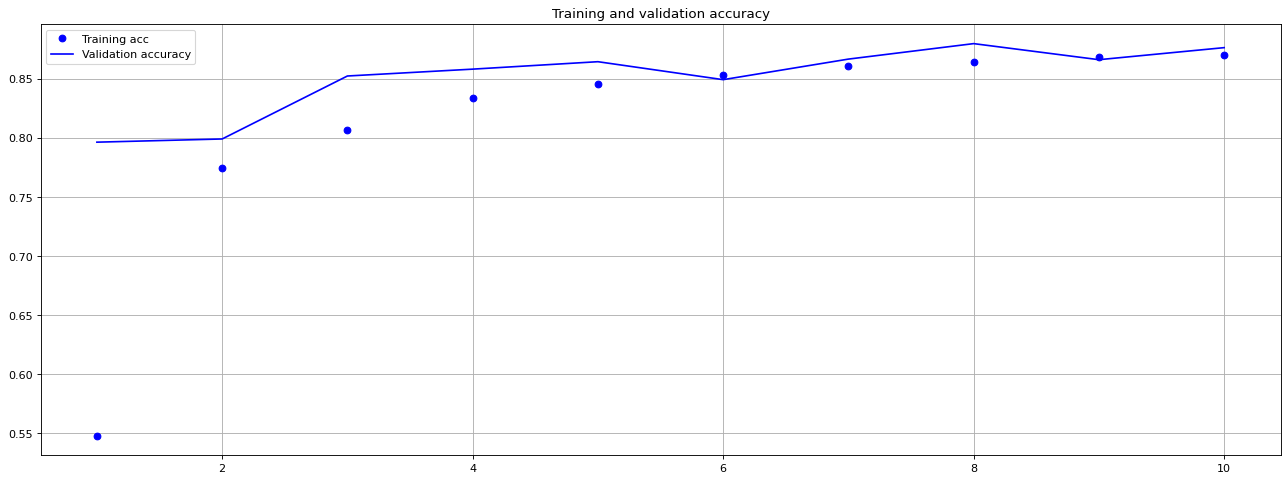

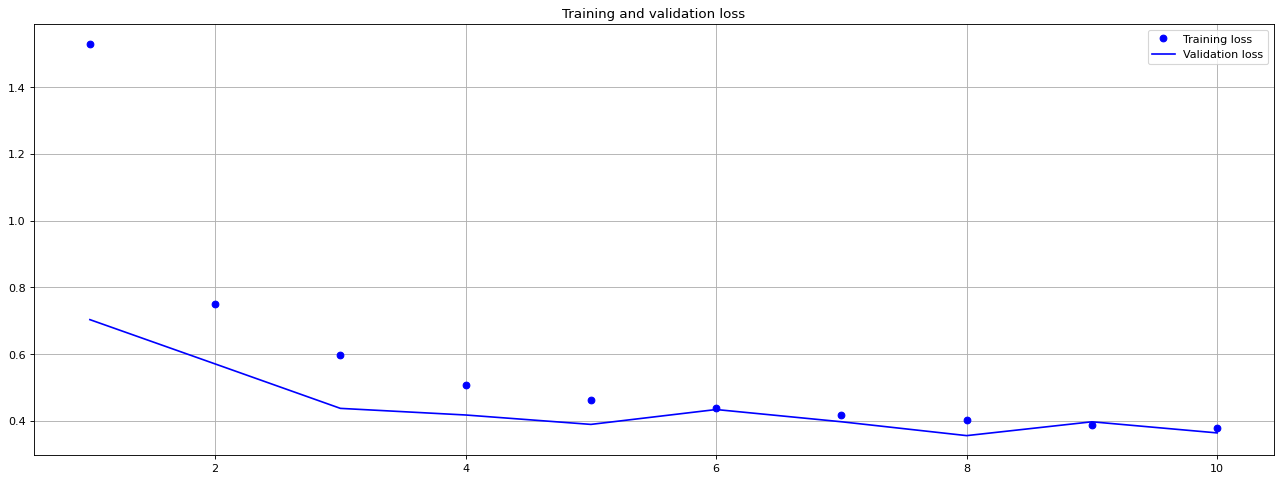

In [9]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [10]:
modified_model.save("modified_model_VGG16.keras")

In [11]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Виведення номерів і назв класів
for idx, class_name in enumerate(class_names):
    print(f'Номер: {idx}, Назва: {class_name}')

Номер: 0, Назва: T-shirt/top
Номер: 1, Назва: Trouser
Номер: 2, Назва: Pullover
Номер: 3, Назва: Dress
Номер: 4, Назва: Coat
Номер: 5, Назва: Sandal
Номер: 6, Назва: Shirt
Номер: 7, Назва: Sneaker
Номер: 8, Назва: Bag
Номер: 9, Назва: Ankle boot


1/1 [==============================] - 0s 102ms/step


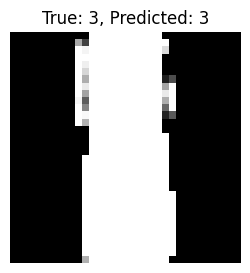

Class probabilities:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 1.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000
1/1 [==============================] - 0s 78ms/step


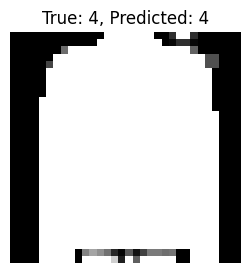

Class probabilities:
Class 0: 0.0007
Class 1: 0.0002
Class 2: 0.1127
Class 3: 0.0026
Class 4: 0.8322
Class 5: 0.0000
Class 6: 0.0509
Class 7: 0.0001
Class 8: 0.0005
Class 9: 0.0001
1/1 [==============================] - 0s 65ms/step


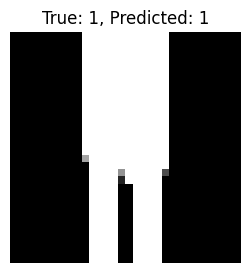

Class probabilities:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000
1/1 [==============================] - 0s 161ms/step


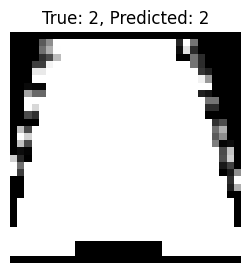

Class probabilities:
Class 0: 0.0014
Class 1: 0.0000
Class 2: 0.9544
Class 3: 0.0003
Class 4: 0.0064
Class 5: 0.0000
Class 6: 0.0373
Class 7: 0.0001
Class 8: 0.0000
Class 9: 0.0000
1/1 [==============================] - 0s 142ms/step


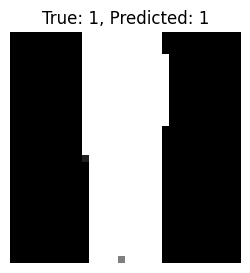

Class probabilities:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000


In [13]:
num_images = 5
indices = np.random.choice(len(test_images), num_images, replace=False)

for idx in indices:
    image = test_images[idx]
    true_label = test_labels[idx]

    # Make predictions
    y_pred_prob = modified_model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(y_pred_prob)

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

    print('Class probabilities:')
    for class_idx, prob in enumerate(y_pred_prob[0]):
        print(f'Class {class_idx}: {prob:.4f}')

In [15]:
import pickle
# Збереження історії навчання
with open('fashion_mnist_model_VGG16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:

from google.colab import files

# Завантаження моделі у форматі HDF5
# files.download('fashion_mnist_model_VGG16.h5')
files.download('/content/modified_model_VGG16.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:

from tensorflow.keras.models import load_model

# model_vgg16_loaded = load_model("fashion_mnist_model_VGG16.h5")
model_vgg16_loaded = load_model("/content/drive/MyDrive/Files/hw13/task2/modified_model_VGG16.keras")
model_vgg16_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 7213322 (27.52 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


**Висновок:** Застосування VGG16 в якості згорткової основи для датасету алгоритмів генератора та подальне донавчання створеної мережі показало покращення точності і інших метрик якості, але неістотно. ТОбто по суті донавчання відбулося на базі вже досягнугнутої точності, але покразилось незначно, навіть беруи під увагу велику кількість епох. Варто відмінити те, що модель, навіть при такій великій кількості епох не стала перенавченою. Але залишилась з відносно невисокими показниками точності - бльзько 0.78.